In [1]:
# 라이브러리 불러오기
import numpy as np
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import RobustScaler
from sklearn.impute import SimpleImputer


In [2]:
# 데이터 불러오기
BASE_DIR = Path.cwd().parent.parent
DATA_DIR = BASE_DIR/'data:raw'

train_df = pd.read_csv(DATA_DIR/'train.csv')
test_df = pd.read_csv(DATA_DIR/'test_x.csv')

TARGET = 'voted'
DROP_COLS = ['index']

print('Train shape: ', train_df.shape)
print('Test shape: ', test_df.shape)


Train shape:  (45532, 78)
Test shape:  (11383, 77)


voted
2    0.546824
1    0.453176
Name: proportion, dtype: float64


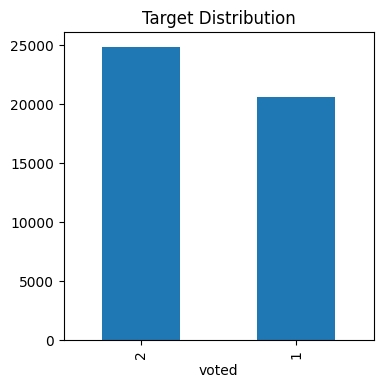

In [3]:
# 기본 EDA
print(train_df[TARGET].value_counts(normalize=True))

plt.figure(figsize=(4, 4))
train_df[TARGET].value_counts().plot(kind='bar')
plt.title('Target Distribution')
plt.show()

In [4]:
# 칼럼 그룹 정의
A_COLS = [col for col in train_df.columns if col.endswith('A')]
E_COLS = [col for col in train_df.columns if col.endswith('E')]

BINARY_COLS = [
    col for col in train_df.columns
    if col.startswith(('tp', 'wf', 'wr'))
]

In [5]:
# 필요 없는 칼럼 제거
train_df = train_df.drop(columns=DROP_COLS)
test_df = test_df.drop(columns=DROP_COLS)

In [6]:
# 결측치 처리
NUM_COLS = A_COLS + E_COLS + BINARY_COLS + ['familysize']

num_imputer = SimpleImputer(strategy='median')
cat_imputer = SimpleImputer(strategy='most_frequent')

CAT_COLS = train_df.select_dtypes(
    include = ['object', 'category', 'string']
). columns.tolist()

train_df[CAT_COLS] = cat_imputer.fit_transform(train_df[CAT_COLS])
test_df[CAT_COLS] = cat_imputer.transform(test_df[CAT_COLS])

In [9]:
#E 계열 파생변수
for col in E_COLS:
    train_df[f'{col}_log'] = np.log1p(train_df[col])
    test_df[f'{col}_log'] = np.log1p(test_df[col])

E_LOG_COLS = [f'{col}_log' for col in E_COLS]

# 클리핑
clip_upper = train_df[E_LOG_COLS].quantile(0.995)

train_df[E_LOG_COLS] = train_df[E_LOG_COLS].clip(upper=clip_upper, axis=1)
test_df[E_LOG_COLS] = test_df[E_LOG_COLS].clip(upper=clip_upper, axis=1)

# 논 제로
for col in E_COLS:
    train_df[f'{col}_nonzero'] = (train_df[col] > 0).astype(int)
    test_df[f'{col}_nonzero'] = (test_df[col] > 0).astype(int)

In [10]:
# familysize 처리
FAMILY_COL = 'familysize'

upper = train_df[FAMILY_COL].quantile(0.99)

train_df[FAMILY_COL] = train_df[FAMILY_COL].clip(upper=upper)
test_df[FAMILY_COL] = test_df[FAMILY_COL].clip(upper=upper)

train_df[FAMILY_COL] = train_df[FAMILY_COL].round().astype(int)
test_df[FAMILY_COL] = test_df[FAMILY_COL].round().astype(int)

def family_bin(x):
    if x == 1:
        return 'single'
    elif x <= 2:
        return 'small'
    elif x <= 4:
        return 'medium'
    elif x <= 6:        
        return 'large'
    else:
        return 'extra_large'

train_df['family_bin'] = train_df[FAMILY_COL].apply(family_bin).astype('category')
test_df['family_bin'] = test_df[FAMILY_COL].apply(family_bin).astype('category')

/var/folders/kf/t62tt0mn3mdc2y72hnq9mv7c0000gn/T/ipykernel_88608/2583707742.py:24: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  train_df['family_bin'] = train_df[FAMILY_COL].apply(family_bin).astype('category')
/var/folders/kf/t62tt0mn3mdc2y72hnq9mv7c0000gn/T/ipykernel_88608/2583707742.py:25: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  test_df['family_bin'] = test_df[FAMILY_COL].apply(family_bin).astype('category')


In [11]:
# 스케일링
SCALE_COLS = A_COLS + E_LOG_COLS

scaler = RobustScaler()
train_df[SCALE_COLS] = scaler.fit_transform(train_df[SCALE_COLS])
test_df[SCALE_COLS] = scaler.transform(test_df[SCALE_COLS])

In [12]:
# feature / target 분리
X_train = train_df.drop(columns=[TARGET])
y_train = train_df[TARGET].astype(np.float32)

X_test = test_df.copy()

In [13]:
# 원 핫 인코딩
CAT_COLS = X_train.select_dtypes(
    include = ['object', 'category', 'string']  
).columns.tolist()

X_train_cat = pd.get_dummies(X_train[CAT_COLS], drop_first=True)
X_test_cat = pd.get_dummies(X_test[CAT_COLS], drop_first=True)

X_train_cat, X_test_cat = X_train_cat.align(
    X_test_cat,
    join='left',
    axis=1,
    fill_value=0
)

X_train_num = X_train.drop(columns=CAT_COLS)
X_test_num = X_test.drop(columns=CAT_COLS)


In [14]:
# 최종 피쳐 결합
X_train_final = pd.concat([X_train_num, X_train_cat], axis=1)
X_test_final = pd.concat([X_test_num, X_test_cat], axis=1)

X_train_final = X_train_final.astype(np.float32)
X_test_final = X_test_final.astype(np.float32)

In [15]:
# 확인
print('X_train: ', X_train_final.shape)
print('X_test: ', X_test_final.shape)

print(X_train_final.dtypes.value_counts())

[col for col in X_train_final.columns if 'family' in col]

X_train:  (45532, 140)
X_test:  (11383, 140)
float32    140
Name: count, dtype: int64


['familysize',
 'family_bin_large',
 'family_bin_medium',
 'family_bin_single',
 'family_bin_small']